In [1]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
import unicodedata
import re
import numpy as np
import os
import time
from pyknp import Jumanpp
import sys
from bert import modeling
from bert import tokenization
from bert import extract_features
import json
from spm import sentencepiece as spm
from sklearn.model_selection import train_test_split
import time
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function
import random
from pyknp import Jumanpp
tf.app.flags.DEFINE_string('f', '', 'kernel')

print(tf.__version__)
print(tf.keras.__version__)


1.13.1
2.2.4-tf


Using TensorFlow backend.


In [2]:
#sp = spm.SentencePieceProcessor()
#spm.SentencePieceTrainer.Train("--input=./tweets/target_text.txt --model_prefix=trained_model--vocab_size=8000")

In [3]:

PAD_ID = 16000

input_path = "./tweets/input_text.txt"
output_path = "./tweets/target_wakachi.txt"
out_voc_path = "./tweets/target_text_voc.txt"
#spm_voc = "./trained_model--vocab_size"
#spm_model = "./trained_model--vocab_size"

BATCH_SIZE = 256
bert_dim = 768
embedding_dim = 256
vocab_out_size = 16001
units = 1024

#bucketの種類
_buckets = [(20,20), (40,40), (60,60), (80,80), (100,100), (140, 145)]




print(tf.__version__)
print(tf.keras.__version__)


1.13.1
2.2.4-tf


In [4]:
#inputのテンソルを付くる
class InputEmbedding():
    def __init__(self, path):
        self.path_txt = path
        self.path_jsonl = path.replace(".txt", ".jsonl")
        
        if os.path.exists(self.path_jsonl):
            pass
        else:
            self.create_jsonl()
        
        #jsonlファイルを作る
    def create_jsonl(self):
        extract_features.main(self.path_txt, self.path_jsonl)
    
    #inputのtensorを作る
    def create_input_tensor(self, line):
        print("Start Creating input-tensor\n")
        input_tensor = []
        i = 0
        with open(self.path_jsonl, 'r') as f:
            output_jsonls = f.readlines()
            for output_jsonl in output_jsonls[(22400)*(line-1):]:
                #sys.stdout.write("{}/{}\n".format(i,len(output_jsonls[(22400)*(line-1):])))
                #sys.stdout.flush()
                output = json.loads(output_jsonl)
                feature = output["features"]
                #1文の中の単語id
                sentence = []
                for layers in feature:
                    layer = layers["layers"]
                    vals = layer[0]
                    val = vals["values"]
                    sentence.append(val)
                input_tensor.append(sentence)
                i += 1
                if(i >= 22400):
                    break
        print("Success Create Input-tensor\n")
                
        return input_tensor

In [5]:
#outputの作成
class OutputIndex():
    def __init__(self, voc_path):
        self.voc_path = voc_path
        self.word2idx = {}
        self.idx2word = {}
        
        self.create_index()
        
    def create_index(self):
        with open(self.voc_path, mode = "r") as voc:
            lines = voc.readlines()
            self.idx2word = dict((i,sen.rstrip("\n"))for i, sen in enumerate(lines[:16000]))
            self.idx2word[PAD_ID] = "PAD"
            
            for index, word in self.idx2word.items():
                self.word2idx[word] = index
            
    def create_output_tensor(self, path, s_line):
        print("Start Creating output-tensor\n")
        output_tensor = []
    
        with open(path, mode = "r") as out:
            lines = out.readlines()
            j = 0
            for i, line in enumerate(lines[(22400)*(s_line-1):]):
                #sys.stdout.write("{}/{}\n".format(i,len(lines[(22400)*(s_line-1):])))
                #sys.stdout.flush()
                
                line = line.rstrip("\n")
                splitted_list = line.split(" ")
                splitted_list.insert(0, "<s>")
                splitted_list.insert(len(splitted_list), "</s>")
                #sys.stdout.write("{}\n".format(splitted_list))
                output_tensor.append([self.word2idx.get(w, 0) for w in splitted_list])
                j += 1
                if(j >= 22400):
                    break
        print("Success Create target-tensor\n")
        
        return output_tensor

In [6]:
#trensorの中の最大長を返す
def max_length(tensor):
    return max(len(t) for t in tensor)

In [7]:
def load_dataset(path_in, path_out, path_voc, line):
    input_obj = InputEmbedding(path_in)
    input_tensor = input_obj.create_input_tensor(line)
    output_obj = OutputIndex(path_voc)
    output_tensor = output_obj.create_output_tensor(path_out,line)

    
    data_set_train = [[] for _ in _buckets]
    for i in range(len(input_tensor)):
        for bucket_id, (inp_size, out_size) in enumerate(_buckets):
            if len(input_tensor[i]) < inp_size and len(output_tensor[i]) < out_size:
                data_set_train[bucket_id].append([input_tensor[i], output_tensor[i]])
                break
                
    del input_tensor
    del output_tensor

    bucket_sizes_train = [len(data_set_train[b]) for b in range(len(_buckets))] 
    print(bucket_sizes_train)
    
    inp_ten, out_ten = Padding(data_set_train)
    return inp_ten, out_ten

In [8]:
def Padding(data):
    encoder_size, decoder_size = _buckets[0]
    print(encoder_size, decoder_size)
    encoder_inputs, decoder_inputs = [], []
    for i in range(len(data[0])):
        encoder_input, decoder_input = random.choice(data[0])
        encoder_pad = [[PAD_ID] * 768] * (encoder_size - len(encoder_input)) 
        encoder_inputs.append(list(encoder_input + encoder_pad))    

        decoder_pad = [PAD_ID] * (decoder_size - len(decoder_input))                
        decoder_inputs.append(decoder_input + [PAD_ID] * (decoder_size - len(decoder_input))) 
        
    batch_encoder_inputs, batch_decoder_inputs, batch_weights = [], [], []


    for batch_idx in range(len(data[0])):                                  
        batch_encoder_inputs.append(np.array([encoder_inputs[batch_idx][length_idx] for length_idx in range(encoder_size)], dtype=np.float32))


    for batch_idx in range(len(data[0])): 
        batch_decoder_inputs.append(np.array([decoder_inputs[batch_idx][length_idx] for length_idx in range(decoder_size)], dtype=np.int32))

    return batch_encoder_inputs, batch_decoder_inputs

In [9]:
def gru(units):
    #if tf.test.is_gpu_available():
       # print("OK")
       # config = tf.ConfigProto()
       #config.gpu_options.allow_growth = True
        
        #return tf.keras.layers.CuDNNGRU(units,return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    #else:
    return tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_activation='sigmoid',recurrent_initializer='glorot_uniform')

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self,enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz,self.dec_units))

In [12]:
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0.)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [13]:
#学習
def train(out_obj):
    EPOCHS = 500
    for epoch in range(EPOCHS):
        splitted_line = 1 #max 10
        start = time.time()
        total_loss = 0
        hidden = encoder.initialize_hidden_state()
        N_BATCH = 0
        while splitted_line <= 10:
            encoder_inputs, decoder_inputs = load_dataset(input_path, output_path, out_voc_path, splitted_line)
            N_BATCH += len(encoder_inputs)/BATCH_SIZE
            
            #テンソル型のデータ作成
            tensor = tf.data.Dataset.from_tensor_slices((encoder_inputs, decoder_inputs)).shuffle(len(encoder_inputs))
            
           # N_BATCH = len(encoder_inputs)/BATCH_SIZE
            tensor = tensor.batch(BATCH_SIZE, drop_remainder=True)
        
            for (batch, (inp, out)) in enumerate(tensor):
                loss = 0
                with tf.GradientTape() as tape:
                
                    enc_output, enc_hidden = encoder(inp, hidden)
            
                    dec_hidden = enc_hidden
            
                    dec_input = tf.expand_dims([out_obj.word2idx["<s>"]] * BATCH_SIZE, 1)       
            
                    # Teacher forcing - feeding the target as the next input
                    for t in range(1, out.shape[1]):
                        # passing enc_output to the decoder
                        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                        predictions = tf.cast(predictions, tf.float32)
                   
                        loss += loss_function(out[:,t], predictions)
                        # using teacher forcing
                        dec_input = tf.expand_dims(out[:, t], 1)
                
                batch_loss = (loss / int(out.shape[1]))
                total_loss += batch_loss
                variables = encoder.variables + decoder.variables   
                gradients = tape.gradient(loss, variables)
                optimizer.apply_gradients(zip(gradients, variables))
                if batch % 50 == 0:
                    print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,batch,batch_loss.numpy()))
            print("Epoch{} : {}% complite".format(epoch, splitted_line*10))
            splitted_line += 1
        
        # saving (checkpoint) the model every 2 epochs
        if (epoch + 1) % 25 == 0:
               checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / N_BATCH))
        total_losses.append(total_loss / N_BATCH)
        
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    return total_losses

In [14]:
#１文をidに変換
def one_sentence(sentence):
    output_jsonls = extract_features.call_bert(sentence)
    feature = output_jsonls["features"]
    #1文の中の単語id
    sen = []
    for layers in feature:
        layer = layers["layers"]
        token = layers["token"]
        print(token)
        vals = layer[0]
        val = vals["values"]
        sen.append(val)
    return sen

In [15]:
def evaluate(sentence, encoder, decoder, out_obj):
    
    inp_bert_id = one_sentence(sentence)
    #インプットがどのバケツに入るかを識別
    #for bucket_id, (inp_size, out_size) in enumerate(_buckets):
        #if len(inp_bert_id) < inp_size:
    inp_bucket_len, out_bucket_len = _buckets[0]
            
    #Padding
    inp_sen = []
    inp_pad = [[PAD_ID] * 768] * (inp_bucket_len - len(inp_bert_id)) 
    inp_sen.append(list(inp_bert_id + inp_pad))
    inp_sen = tf.convert_to_tensor(inp_sen, dtype = tf.float32)
    #print(type(in))
    
    attention_plot = np.zeros((out_bucket_len,inp_bucket_len ))
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inp_sen, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([out_obj.word2idx["<s>"]], 0)

    for t in range(out_bucket_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += out_obj.idx2word[predicted_id]

        if out_obj.idx2word[predicted_id] == "</s>":
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [16]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [21]:
def translate(sentence, encoder, decoder, out_obj):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, out_obj)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    juman = Jumanpp()
    u_analysis = juman.analysis(sentence)
    u_sen = []
    for m in u_analysis.mrph_list():
        u_sen.append(str(m.midasi))
        
    s_analysis = juman.analysis(result)
    s_sen = []
    for n in s_analysis.mrph_list():
        s_sen.append(str(n.midasi))
   
    
    attention_plot = attention_plot[:len(s_sen), :len(u_sen)]
    plot_attention(attention_plot, u_sen, s_sen)

In [18]:
optimizer = tf.train.AdamOptimizer()
total_losses = []
encoder = Encoder(units, BATCH_SIZE)
decoder = Decoder(vocab_out_size, embedding_dim, units, BATCH_SIZE)
checkpoint_dir = './training_checkpoints_with_bert'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")               
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder,decoder=decoder)
out_obj = OutputIndex(out_voc_path)
train(out_obj)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17507, 4893, 0, 0, 0, 0]
20 20
Instructions for updating:
Colocations handled automatically by placer.
Epoch 1 Batch 0 Loss 8.4651
Epoch 1 Batch 50 Loss 2.6028
Epoch0 : 10% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17288, 5112, 0, 0, 0, 0]
20 20
Epoch 1 Batch 0 Loss 2.4884
Epoch 1 Batch 50 Loss 2.3746
Epoch0 : 20% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17124, 5276, 0, 0, 0, 0]
20 20
Epoch 1 Batch 0 Loss 2.5634
Epoch 1 Batch 50 Loss 2.3289
Epoch0 : 30% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17266, 5133, 1, 0, 0, 0]
20 20
Epoch 1 Batch 0 Loss 2.1838
Epoch 1 Batch 50 Loss 2.0518
Epoch0 : 40% complite
Start Creati

Epoch 4 Batch 0 Loss 1.9098
Epoch 4 Batch 50 Loss 1.9399
Epoch3 : 40% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17221, 5179, 0, 0, 0, 0]
20 20
Epoch 4 Batch 0 Loss 1.8753
Epoch 4 Batch 50 Loss 1.7990
Epoch3 : 50% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17049, 5351, 0, 0, 0, 0]
20 20
Epoch 4 Batch 0 Loss 1.7274
Epoch 4 Batch 50 Loss 1.6999
Epoch3 : 60% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17483, 4917, 0, 0, 0, 0]
20 20
Epoch 4 Batch 0 Loss 1.7707
Epoch 4 Batch 50 Loss 1.7815
Epoch3 : 70% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17286, 5114, 0, 0, 0, 0]
20 20
Epoch 4 Batch 0 Loss 1.6734
Epoch 4 Batch 50 Loss 1.6060
Epoch3 : 80% complite
Start

Epoch 7 Batch 0 Loss 1.8121
Epoch 7 Batch 50 Loss 1.6760
Epoch6 : 90% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17307, 5093, 0, 0, 0, 0]
20 20
Epoch 7 Batch 0 Loss 1.6608
Epoch 7 Batch 50 Loss 1.7980
Epoch6 : 100% complite
Epoch 7 Loss 1.6852
Time taken for 1 epoch 1387.3406648635864 sec

Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17507, 4893, 0, 0, 0, 0]
20 20
Epoch 8 Batch 0 Loss 1.7340
Epoch 8 Batch 50 Loss 1.6699
Epoch7 : 10% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17288, 5112, 0, 0, 0, 0]
20 20
Epoch 8 Batch 0 Loss 1.7502
Epoch 8 Batch 50 Loss 1.6313
Epoch7 : 20% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17124, 5276, 0, 0, 0, 0]
20 20
Epoch 8 Batch 0 

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17266, 5133, 1, 0, 0, 0]
20 20
Epoch 11 Batch 0 Loss 1.6695
Epoch 11 Batch 50 Loss 1.6397
Epoch10 : 40% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17221, 5179, 0, 0, 0, 0]
20 20
Epoch 11 Batch 0 Loss 1.6220
Epoch 11 Batch 50 Loss 1.5752
Epoch10 : 50% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17049, 5351, 0, 0, 0, 0]
20 20
Epoch 11 Batch 0 Loss 1.7409
Epoch 11 Batch 50 Loss 1.5829
Epoch10 : 60% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17483, 4917, 0, 0, 0, 0]
20 20
Epoch 11 Batch 0 Loss 1.6787
Epoch 11 Batch 50 Loss 1.5515
Epoch10 : 70% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Creat

Epoch 14 Batch 0 Loss 1.7842
Epoch 14 Batch 50 Loss 1.6515
Epoch13 : 80% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17398, 5002, 0, 0, 0, 0]
20 20
Epoch 14 Batch 0 Loss 1.7055
Epoch 14 Batch 50 Loss 1.4667
Epoch13 : 90% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17307, 5093, 0, 0, 0, 0]
20 20
Epoch 14 Batch 0 Loss 1.5507
Epoch 14 Batch 50 Loss 1.5713
Epoch13 : 100% complite
Epoch 14 Loss 1.5942
Time taken for 1 epoch 1350.7807648181915 sec

Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17507, 4893, 0, 0, 0, 0]
20 20
Epoch 15 Batch 0 Loss 1.5841
Epoch 15 Batch 50 Loss 1.4644
Epoch14 : 10% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17288, 5112, 0, 0, 0, 0]
20 20
Epo

Epoch17 : 20% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17124, 5276, 0, 0, 0, 0]
20 20
Epoch 18 Batch 0 Loss 1.7124
Epoch 18 Batch 50 Loss 1.4754
Epoch17 : 30% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17266, 5133, 1, 0, 0, 0]
20 20
Epoch 18 Batch 0 Loss 1.6513
Epoch 18 Batch 50 Loss 1.4591
Epoch17 : 40% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17221, 5179, 0, 0, 0, 0]
20 20
Epoch 18 Batch 0 Loss 1.5984
Epoch 18 Batch 50 Loss 1.5173
Epoch17 : 50% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17049, 5351, 0, 0, 0, 0]
20 20
Epoch 18 Batch 0 Loss 1.5721
Epoch 18 Batch 50 Loss 1.5581
Epoch17 : 60% complite
Start Creating input-tensor

Success Create Input

[17483, 4917, 0, 0, 0, 0]
20 20
Epoch 21 Batch 0 Loss 1.6215
Epoch 21 Batch 50 Loss 1.5508
Epoch20 : 70% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17286, 5114, 0, 0, 0, 0]
20 20
Epoch 21 Batch 0 Loss 1.6171
Epoch 21 Batch 50 Loss 1.4941
Epoch20 : 80% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17398, 5002, 0, 0, 0, 0]
20 20
Epoch 21 Batch 0 Loss 1.6149
Epoch 21 Batch 50 Loss 1.3923
Epoch20 : 90% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17307, 5093, 0, 0, 0, 0]
20 20
Epoch 21 Batch 0 Loss 1.5827
Epoch 21 Batch 50 Loss 1.4585
Epoch20 : 100% complite
Epoch 21 Loss 1.4849
Time taken for 1 epoch 1457.8368451595306 sec

Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17

Epoch 25 Batch 0 Loss 1.5404
Epoch 25 Batch 50 Loss 1.3714
Epoch24 : 10% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17288, 5112, 0, 0, 0, 0]
20 20
Epoch 25 Batch 0 Loss 1.6117
Epoch 25 Batch 50 Loss 1.3912
Epoch24 : 20% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17124, 5276, 0, 0, 0, 0]
20 20
Epoch 25 Batch 0 Loss 1.5655
Epoch 25 Batch 50 Loss 1.4150
Epoch24 : 30% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17266, 5133, 1, 0, 0, 0]
20 20
Epoch 25 Batch 0 Loss 1.5015
Epoch 25 Batch 50 Loss 1.3740
Epoch24 : 40% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17221, 5179, 0, 0, 0, 0]
20 20
Epoch 25 Batch 0 Loss 1.6400
Epoch 25 Batch 50 Loss 1.3614
Epoch24 : 50%

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17049, 5351, 0, 0, 0, 0]
20 20
Epoch 28 Batch 0 Loss 1.6195
Epoch 28 Batch 50 Loss 1.3781
Epoch27 : 60% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17483, 4917, 0, 0, 0, 0]
20 20
Epoch 28 Batch 0 Loss 1.4698
Epoch 28 Batch 50 Loss 1.3152
Epoch27 : 70% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17286, 5114, 0, 0, 0, 0]
20 20
Epoch 28 Batch 0 Loss 1.6344
Epoch 28 Batch 50 Loss 1.3412
Epoch27 : 80% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17398, 5002, 0, 0, 0, 0]
20 20
Epoch 28 Batch 0 Loss 1.4610
Epoch 28 Batch 50 Loss 1.2945
Epoch27 : 90% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Creat

Epoch 31 Batch 0 Loss 1.5328
Epoch 31 Batch 50 Loss 1.2801
Epoch30 : 100% complite
Epoch 31 Loss 1.3924
Time taken for 1 epoch 1395.8342344760895 sec

Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17507, 4893, 0, 0, 0, 0]
20 20
Epoch 32 Batch 0 Loss 1.4834
Epoch 32 Batch 50 Loss 1.4811
Epoch31 : 10% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17288, 5112, 0, 0, 0, 0]
20 20
Epoch 32 Batch 0 Loss 1.6797
Epoch 32 Batch 50 Loss 1.3823
Epoch31 : 20% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17124, 5276, 0, 0, 0, 0]
20 20
Epoch 32 Batch 0 Loss 1.6311
Epoch 32 Batch 50 Loss 1.3797
Epoch31 : 30% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17266, 5133, 1, 0, 0, 0]
20 20
Epo

Epoch 35 Batch 50 Loss 1.3110
Epoch34 : 40% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17221, 5179, 0, 0, 0, 0]
20 20
Epoch 35 Batch 0 Loss 1.4443
Epoch 35 Batch 50 Loss 1.2437
Epoch34 : 50% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17049, 5351, 0, 0, 0, 0]
20 20
Epoch 35 Batch 0 Loss 1.3967
Epoch 35 Batch 50 Loss 1.2937
Epoch34 : 60% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17483, 4917, 0, 0, 0, 0]
20 20
Epoch 35 Batch 0 Loss 1.5143
Epoch 35 Batch 50 Loss 1.1662
Epoch34 : 70% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17286, 5114, 0, 0, 0, 0]
20 20
Epoch 35 Batch 0 Loss 1.5653
Epoch 35 Batch 50 Loss 1.2436
Epoch34 : 80% complite
Start Creating inpu

Success Create target-tensor

[17398, 5002, 0, 0, 0, 0]
20 20
Epoch 38 Batch 0 Loss 1.4462
Epoch 38 Batch 50 Loss 1.1914
Epoch37 : 90% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17307, 5093, 0, 0, 0, 0]
20 20
Epoch 38 Batch 0 Loss 1.4146
Epoch 38 Batch 50 Loss 1.1936
Epoch37 : 100% complite
Epoch 38 Loss 1.2664
Time taken for 1 epoch 1386.2977349758148 sec

Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17507, 4893, 0, 0, 0, 0]
20 20
Epoch 39 Batch 0 Loss 1.4283
Epoch 39 Batch 50 Loss 1.1409
Epoch38 : 10% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17288, 5112, 0, 0, 0, 0]
20 20
Epoch 39 Batch 0 Loss 1.5370
Epoch 39 Batch 50 Loss 1.2541
Epoch38 : 20% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Suc

Epoch 42 Batch 0 Loss 1.5330
Epoch 42 Batch 50 Loss 1.2065
Epoch41 : 30% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17266, 5133, 1, 0, 0, 0]
20 20
Epoch 42 Batch 0 Loss 1.4640
Epoch 42 Batch 50 Loss 1.2078
Epoch41 : 40% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17221, 5179, 0, 0, 0, 0]
20 20
Epoch 42 Batch 0 Loss 1.4756
Epoch 42 Batch 50 Loss 1.2095
Epoch41 : 50% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17049, 5351, 0, 0, 0, 0]
20 20
Epoch 42 Batch 0 Loss 1.4713
Epoch 42 Batch 50 Loss 1.1967
Epoch41 : 60% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17483, 4917, 0, 0, 0, 0]
20 20
Epoch 42 Batch 0 Loss 1.4885
Epoch 42 Batch 50 Loss 1.0994
Epoch41 : 70%

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17286, 5114, 0, 0, 0, 0]
20 20
Epoch 45 Batch 0 Loss 1.3810
Epoch 45 Batch 50 Loss 1.1060
Epoch44 : 80% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17398, 5002, 0, 0, 0, 0]
20 20
Epoch 45 Batch 0 Loss 1.3839
Epoch 45 Batch 50 Loss 1.1969
Epoch44 : 90% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17307, 5093, 0, 0, 0, 0]
20 20
Epoch 45 Batch 0 Loss 1.3404
Epoch 45 Batch 50 Loss 1.0901
Epoch44 : 100% complite
Epoch 45 Loss 1.1790
Time taken for 1 epoch 1401.6275503635406 sec

Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17507, 4893, 0, 0, 0, 0]
20 20
Epoch 46 Batch 0 Loss 1.3402
Epoch 46 Batch 50 Loss 1.1088
Epoch45 : 10% complite
Start Creating input-tensor

Suc

Success Create target-tensor

[17288, 5112, 0, 0, 0, 0]
20 20
Epoch 49 Batch 0 Loss 1.5018
Epoch 49 Batch 50 Loss 1.1085
Epoch48 : 20% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17124, 5276, 0, 0, 0, 0]
20 20
Epoch 49 Batch 0 Loss 1.3304
Epoch 49 Batch 50 Loss 1.1071
Epoch48 : 30% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17266, 5133, 1, 0, 0, 0]
20 20
Epoch 49 Batch 0 Loss 1.3140
Epoch 49 Batch 50 Loss 1.0547
Epoch48 : 40% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17221, 5179, 0, 0, 0, 0]
20 20
Epoch 49 Batch 0 Loss 1.4103
Epoch 49 Batch 50 Loss 1.1105
Epoch48 : 50% complite
Start Creating input-tensor

Success Create Input-tensor

Start Creating output-tensor

Success Create target-tensor

[17049, 5351, 0, 0, 0, 0]
20 20
Epoch 49 B

KeyboardInterrupt: 

In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

['今日', 'は', '暑い', 'ね']
INFO:tensorflow:*** Example ***
INFO:tensorflow:unique_id: 0
INFO:tensorflow:tokens: [CLS] 今日 は 暑い ね [SEP]
INFO:tensorflow:input_ids: 2 2281 9 30830 2382 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:

INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:te

INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/

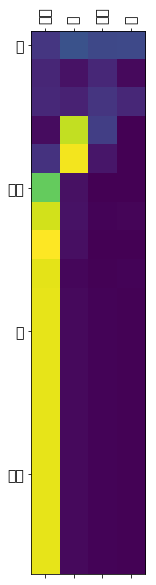

In [24]:
#out_obj = OutputIndex(spm_voc, spm_model)
translate("今日は暑いね", encoder, decoder, out_obj)